# <div align="center">Project 2b: Correlation Power Analysis (CPA) - Data Analysis<div>

<p><div align="center">Due Date: Sunday April 26th, 2020, 11:59 PM</div></p>

<div align="center"><b>You are expected to work in groups of two. Address all questions listed in this document in your final report. Submit the report on <a href="https://mymasonportal.gmu.edu" target="_blank">MyMason</a> in PDF format.</div>

In this part of the project, you will use the traces you collected in the first part of the project to complete the steps of the CPA attack and recover the key.

## Side Channel Analysis Process

### Step 1: Point of Attack and Power Model
This step was performed in Project 2 part a).

### Step 2: Data Acquisition - Power Measurements
This step was performed in Project 2 part a).

### Step 3: Calculating Hypothetical Power
In Step 1, we analyzed the implementation of the cryptographic algorithm to determine a possible point of attack.
We choose it to be the point in time where an intermediate result is computed as a funcion of a known data value and the key. The intermediate value is calculated as *f(d, k)* where *d* is a known non-constant value that can be derived from known data (e.g. plaintext) and *k* is small part of the key.

![AES Block Diagram](figures/aes128.png "AES Block Diagram")

We decided to attack our AES design during the first round at the output of the register FF1 as indicated in the figure above. The hypothetical power $\mathbf{H}$ is calculated for each data value $d_i$ and each key guess $k_j$  using the Hamming Distance (HD) equation. As we use two data values, ciphertext $CT$ and plaintext $PT$, our equation looks as follows.

\begin{equation}
h(i,j) = HD(SBOX(CT_i), SBOX(k_j \oplus PT_{i+1} ))
\end{equation}

We have to repeat this calculation for every byte of the key, using the corresponding bytes from $CT$ and $PT$.
We use the HD model since it is suitable for CMOS technology and we know the the value of the intermediate at the attack point on two consecutive clock cycles.

In this part of the attack we will be calculating this hypothetical power model for each subkey byte using the plaintexts we provided, the ciphertexts we obtained when encrypting the ciphertexts and the formula above. This computation has to be performed only once unless we change the plaintext or the key.


### Step 4: Data Analysis
Correlation Power Analysis (CPA) is a form of Differential Power Analysis (DPA) which uses a
statistical test, also called a side-channel distinguisher, to correlate power samples with the power
model in order to obtain the secret key. The only side-channel distinguisher that FOBOS currently supports is *Pearson's product moment correlation coefficient (r)*. The Pearson’s correlation (r) between the the power consumption of the device $\mathbf{T}$ and the hypothetical power model $\mathbf{H}$ is given by

\begin{equation}\label{eq:pearsons-r}
r(i,j) =\frac{D \sum_{d=1}^{D}{t_{d,j} h_{d,i}}-\sum_{d=1}^{D} t_{d,j}\sum_{d}^{D}h_{d,i}}
          {\sqrt{D\sum_{d=1}^{D} t_{d,j}^2-\left(\sum_{d=1}^{D} t_{d,j}\right)^2} 
           \sqrt{D\sum_{d=1}^{D} h_{d,i}^2-\left(\sum_{d=1}^{D} h_{d,i}\right)^2}}
\end{equation}   

where $D$ is the number of traces, $t_d$ is trace $d$. This function has to be iterated over all key guesses $i=1,\ldots, K$ and samples $j=1,\ldots, T$. Then this whole process has to be repeated for each key byte.

FOBOS computes Pearson’s correlation for each sample, each key guess and for each key byte.



## FOBOS Analysis Setup

### Libraries and Acquisition Results:

First we have to load the necessary libraries.

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import fobos.traceset as traceset 
import fobos.cpa as cpa
import fobos.projmgr as projmgr
import fobos.powermodels.AESFirstLast as powermodel #code to calculate hypothetical power
import fobos.powermodels.utils as powermodelUtils

FOBOS Analysis needs to know the directory in which the measurements are stored and the accompanying acquisition settings. 

* **WORKSPACE** is the location of the <code>capture</code> directory that got created for the acquisition step as **workspace**/**projectName**/capture. Inside this directory, each time an acquisition was performed an **ATTEMPT_DIR** was created, named <code>attempt-</code>*number*. 
* **ATTEMPT_DIR** contains the measurements, ciphertext, and the acquisition settings.



In [4]:
# Configure project directories 
WORKSPACE = "fobosworkspace/aes/capture"        # Workspace for FOBOS Analysis
ATTEMPT_DIR = "attempt-02"                        # the location is likely in the form attampt-i (e.g. attempt-1)
###########################
pm = projmgr.ProjectManager()
pm.setWorkSpaceDir(WORKSPACE)
pm.setProjName(ATTEMPT_DIR)
projDir = pm.getProjDir()
analysisDir = pm.getAnalysisDir()

Successfully created new analysis directory at fobosworkspace/aes/capture/attempt-02/analysis/attempt-01


<span style="color:red">The previous cell generated a new analysis directory. Note the attempt-xx directory number. All output files will be stored there.</span>


### Files and Locations:

Now we can load the acquistion settings. The only thing that has to be specified is the location for storing the computed power model. The locations of the other files is retrieved from the acquisition configuration.

* HYPO_FILE is the location for storing the hypothetical power model.

In [5]:
cpaConf = {}
configFile = open(os.path.join(projDir, 'acquisitionConfig.json'))
acqConf = json.load(configFile)
print(f'Acquisition config = {acqConf}')
cpaConf['traceNum'] = acqConf['traceNum']

# Configure file names
HYPO_FILE = os.path.join(projDir, "hypotheticalPower.npy") # Name of file for storing the power model
#############################
TRACES_FILE = os.path.join(projDir, acqConf['traceFile'])  # Name of file for recording power traces
PLAIN_FILE = os.path.join(projDir, acqConf['plainFile'])   # plaintext in hex
CIPHER_FILE = os.path.join(projDir, acqConf['cipherFile']) # observed ciphertext, result from applying test vectors

Acquisition config = {'ip': '192.168.10.99', 'port': 9995, 'workspace': 'fobosworkspace', 'projectName': 'aes', 'plainFile': 'plaintext.txt', 'keyFile': 'key.txt', 'dinFile': 'dinFile.txt', 'bitFile': 'half_duplex_dut.bit', 'cipherFile': 'ciphertext.txt', 'traceFile': 'powerTraces.npy', 'traceNum': 4000, 'DUTClk': 1, 'samplingFreq': 50, 'samplesPerTrace': 300, 'ADCGain': 50, 'outLen': 16}


## Power Model Computation


Run the following cell to calculate the hypothetical power matrix. This uses the plaintexts we provided during acquisition, the ciphertexts we obtained when encrypting the ciphertexts and the HD formula above.


If this model has already been computed, it will not be computed again, but the file containing the hypothetical power model will be loaded. You can force it to recompute the power model by only runing the last two lines of code in the cell below.

In either case, the cell will show as output the hypothetical power matrix for each subkey. 

<div class="alert alert-block alert-info">

#### Questions:

1. Why are the entries in the hypothetical power matrix only numbers from '0' to '8' ?
2. How many entries are on each line and what do they represent.
3. How many rows does the hypothetical power model have? Why do we need so many rows.
4. How many power models do we need.
5. (10 bonus points for complete answer) For subkey=0, keyguess=0, ciphertext $CT_1$, and plaintext $PT_2$, show how the hamming distance equation above computes the hamming distance. Subkey 0 is influenced by the lease significant byte (LSB) of plaintext and ciphertext. Open the files <code>plaintext.txt</code> and <code>ciphertext.txt</code> to determine the values for $CT_1$ and $PT_2$. Then look at the hypothetical power matrix for subkey 0 and confirm that you computed the correct value.
</div>


In [6]:
if os.path.isfile(HYPO_FILE):
    # already exists. load it
    hypotheticalPower = powermodelUtils.loadHypoPower(HYPO_FILE)
else:
    # not there. generate it
    hypotheticalPower = powermodel.getHypotheticalPower(PLAIN_FILE,
                                                    CIPHER_FILE,
                                                    acqConf['traceNum'])
    powermodelUtils.saveHypoPower(hypotheticalPower, HYPO_FILE)

powermodelUtils.showHypoPower(hypotheticalPower, plainFile=PLAIN_FILE, cipherFile=CIPHER_FILE)
# Command to show power model, no need to show in getHypotheticalPower 
# powermodelUtils.showHypoPower(PLAIN_FILE, CIPHER_FILE, hypotheticalPower)
 ###done but plaintext/ciphertext is displayed only when hypo power is generated 

---- Loading powermodel input data:
Plaintext :
Matrix shape is (10000, 16)
[[51 72 1 ... 87 7 3]
 [b3 34 ba ... 8b de 7b]
 [45 86 34 ... 57 c2 26]
 ...
 [5b 19 bc ... f9 6 ad]
 [63 f 9 ... 42 e9 b7]
 [6a 24 a3 ... c9 d e1]]

Ciphertext :
Matrix shape is (4000, 16)
[[8e 6c 7 ... 16 a7 a2]
 [50 61 d8 ... e6 e0 9f]
 [78 f4 c3 ... 82 87 fe]
 ...
 [d3 72 17 ... bf 7a a3]
 [f8 ff 72 ... e 78 ee]
 [f7 f2 c9 ... 38 47 89]]

---- Loading powermodel input data complete.
---- Calculating hypothetical power for all subkeys:
---- Hypothetical power calculation done.
Saving hypthetical power to fobosworkspace/aes/capture/attempt-02/hypotheticalPower.npy.
saving done.
Power model :
Hypothetical power matrix for subkey 0:
Matrix shape is (4000, 256)
[[4 4 6 ... 3 5 4]
 [4 4 4 ... 4 6 2]
 [5 2 6 ... 6 5 5]
 ...
 [4 3 5 ... 4 5 5]
 [4 4 6 ... 4 4 5]
 [6 6 4 ... 1 5 3]]

Hypothetical power matrix for subkey 1:
Matrix shape is (4000, 256)
[[1 5 3 ... 5 3 5]
 [2 4 4 ... 4 2 5]
 [5 5 3 ... 5 4 4]
 ...
 [6 

## FOBOS Analysis

### Loading Measurements

First, lets load the traces by running the following cell, and show what they look like.

Loading raw traces from file: fobosworkspace/aes/capture/attempt-02/powerTraces.npy
Please wait ...
Max number of samples in the first 10 traces is: 300
Loading done.
The shape of the traces matrix is (100, 300)


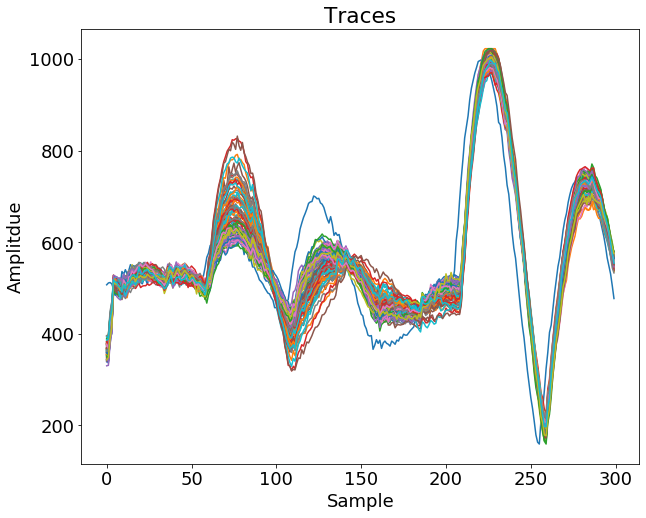

In [7]:
##plotting settings
cpaConf['plot'] = True
cpaConf['plotSize'] = (10,8)
cpaConf['plotFontSize'] = 18
# load traces from file.
traceSetOrig = traceset.TraceSet(traceNum=min(100,cpaConf['traceNum']),
                            fileName=TRACES_FILE)

measuredPowerOrig = traceSetOrig.traces
print(f'The shape of the traces matrix is {measuredPowerOrig.shape}')


maxtrace = 100
plt.figure(figsize=cpaConf['plotSize'])
plt.rcParams.update({'font.size': cpaConf['plotFontSize']})
plt.xlabel('Sample')
plt.ylabel('Amplitdue')
plt.title('Traces')
for i in range(min(maxtrace, cpaConf['traceNum'])):
    plt.plot(measuredPowerOrig[i])


### Analysis Configuration

During Acquisition, we already shortened the length of the traces to stop somewhere near the end of the *interesting* clock cycle, i.e. the point of attack. Unfortunatley, we were not able to start the trace closer to the beginning of the *interesting* clock cycle.

FOBOS Analysis can crop the traces, so that it computes the correlation coefficients for fewer samples. It uses the following two parameters:

* <code>cropStart</code> specifies the first sample in a trace that should be analyzed.
* <code>cropEnd</code> specifies the last samaple in a trace that should be analyzed.


<div class="alert alert-block alert-info">

#### Questions:

6. Looking at the trace graph above, what is the range of samples for the first clock cycle (Hint: AES starts after loading data)? Set the <code>cropStart</code> and <code>cropEnd</code> parameters in the code below and run the cell.
</div>

In [8]:
cpaConf['cropStart'] = 200
cpaConf['cropEnd'] = 250
#cpaConf['traceNum'] = 4000  # override acquisiton_config parameter here
# save config file
cpaConfFile = open(os.path.join(analysisDir, 'cpaConfig.json'), 'w')
cpaConfFile.write(json.dumps(cpaConf, indent=4))
cpaConfFile.close()

Now plot the graph with the cropped traces.

Loading raw traces from file: fobosworkspace/aes/capture/attempt-02/powerTraces.npy
Please wait ...
Max number of samples in the first 10 traces is: 300
Loading done.
The shape of the traces matrix is (4000, 50)


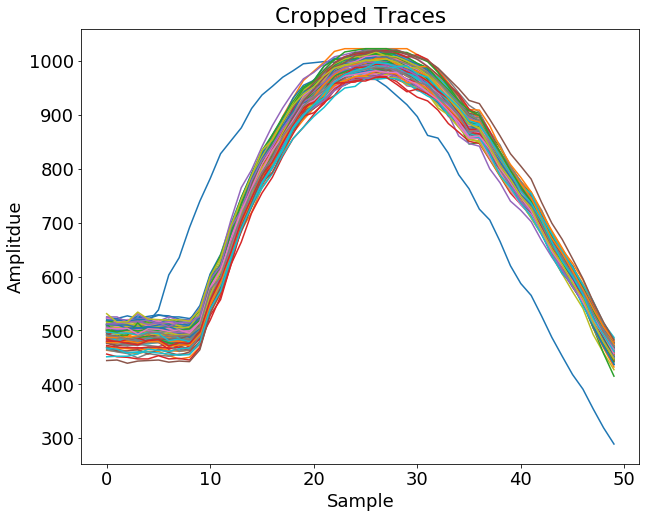

In [9]:
# load traces from file.
traceSet = traceset.TraceSet(traceNum=cpaConf['traceNum'],
                            fileName=TRACES_FILE,
                            cropStart=cpaConf['cropStart'],
                            cropEnd=cpaConf['cropEnd'])

measuredPower = traceSet.traces
print(f'The shape of the traces matrix is {measuredPower.shape}')


maxtrace = 100
plt.figure(figsize=cpaConf['plotSize'])
plt.rcParams.update({'font.size': cpaConf['plotFontSize']})
plt.xlabel('Sample')
plt.ylabel('Amplitdue')
plt.title('Cropped Traces')
for i in range(min(maxtrace, cpaConf['traceNum'])):
    plt.plot(measuredPower[i])


<div class="alert alert-block alert-info">

#### Questions:
7. Include the graph of the cropped traces in your report.
</div>

## Correlation Power Analysis (CPA) Attack

The following cell will run the attack. You can configure two parameters:

* <code>plot</code> **True** will plot correlation and MTD graphs, **False** will save time by not plotting the graphs.
* <code>numKeys</code> lets you set how many subkeys the attack should try to recover. The more subkeys, the more time it will take.

Therefore, when fine tuning parameters of acquisition and analysis set <code>plot</code> to **False** and <code>numKyes</code> to **1**. These are the default values.

Now run the following cell to run the attack. With plots and for all subkeys it will take few minutes to finish. This will use the hypothetical power matrix (for eack key byte) and the traces collected from the hardware.

In [10]:
# Configure the attack
cpaConf['plot'] = True # generate plots, [True|False], default: False
numKeys = 16             # number of subkey bytes to attack, default: 1
#####################
# Run the attack
cpaAttacker = cpa.CPA()
C = cpaAttacker.doCPA(measuredPower=measuredPower,
                      hypotheticalPower=hypotheticalPower,
                      numTraces= cpaConf['traceNum'],
                      analysisDir=analysisDir,
                      MTDStride= 100,
                      numKeys = numKeys,
                      plot=cpaConf['plot'], # enable/disable plots
                      plotSize=cpaConf['plotSize'],
                      plotFontSize=cpaConf['plotFontSize']
                      )

Running CPA attack. Please wait ...
subkey number = 0, subkey value = 0x1, correlation = 0.06553349241560535, at sample = 25
    plotting correlation graph.
    Plotting MTD graph.
subkey number = 1, subkey value = 0x23, correlation = 0.11028708406463136, at sample = 27
    plotting correlation graph.
    Plotting MTD graph.
subkey number = 2, subkey value = 0x45, correlation = 0.08470737987780742, at sample = 30
    plotting correlation graph.
    Plotting MTD graph.
subkey number = 3, subkey value = 0x67, correlation = 0.10816152626674341, at sample = 30
    plotting correlation graph.
    Plotting MTD graph.
subkey number = 4, subkey value = 0x89, correlation = 0.10621881343699222, at sample = 31
    plotting correlation graph.
    Plotting MTD graph.
subkey number = 5, subkey value = 0xab, correlation = 0.11516245318494978, at sample = 25
    plotting correlation graph.
    Plotting MTD graph.
subkey number = 6, subkey value = 0xcd, correlation = 0.08955074994139145, at sample = 29

<div class="alert alert-block alert-info">

#### Questions:
8.  If the script above found a subkey value, record the value, correlation value and sample 
    number in your report. If not, please change the crop settings and try again.
9.  Open the file <code>key.txt</code> that you saw during the acquisition step and check if the subkey that 
    was found matches the most significant byte (MSB), i.e. left most in the file. 
    This file should be in <code>fobosworkspace/aes</code>. If it does not match,
    change the crop settings and try again. If it still does not match, you might have to go back
    to the data acquisition and change settings there. Please read the instructions carefully.
10. Open the file <code>topKeys-00.json</code> in the <code>analysis/attempt-</code>*number* 
    directory and examine the top 5 key guesses, correlation values, and time (sample number) 
    that were found.
    Note: The key guesses are here decimal and not hexadecimal notation.  Time is given as sample
    number within the cropped sample window, e.g. when you choose a crop start at 100, then the
    time value of 50 in the file mapps to the actual sample number 100+50=150.
    Copy this data as a table into your report.
11. Now change the number of keys to match the number of subkeys bytes of AES. Also set <code>plot</code>
    to **True** to generate the graphs. Run the attack again. 
    Note the number of subkeys in your report. 
12. The result of the attack above shows the sample numbers where each subkey byte was found. 
    The sample numbers are in relation to the start of the cropped sample window. What
    is the range of these sample numbers. Add the crop start to the sample number to get the
    absolute sample number of the original trace.
13. Why do we not get all subkey bytes from the same sample number. After all, this implementation
    of AES, as shown in the block diagram above, applies all subkey bytes at the same time.
</div>



FOBOS generates two types of graphs for you. The first is the **Measurement to Disclosure (MTD)** graphs. It shows on the x-axis the number of traces analyzed and on the y-axis in blue the highest and the lowest correlation value found for any key guess except the presumed correct one, for that many analyzed traces. Additionally, it shows in red the correlation for the assumed correct sub key. The number of traces where the red curve (presumed correct key) leaves the space between the blue lines (best other key guesses), shows the minimum number of traces required to obtain this sub key byte.

The other graph, **Correlation** graph, shows on the x-axis the sample number, based on the start of the cropped sample window, and on the y-axis the correlation value. From this graph you can see when in time (sample number) the correlation is the highest.

The graphs will be generated in the <code>fobosworkspace/aes/attempt-xx/analysis/attempt-</code>*number* directory.

<div class="alert alert-block alert-info">

#### Questions:
14. Copy the MTD and the Correlation graph for subkey byte 0 into your report.
15. Determine the range of MTD for the different subkey bytes.
16. What is the minimum number of traces needed for full subkey recovery?
17. Why do some key bytes require fewer measurements than others.

The last questions are about your experience with this project.
<div class="alert alert-block alert-info">

#### Questions:
18. How much time did you spend on the **data acquisition part**.
19. What concept was the hardest to understand.
20. Which step took the most time.
19. How much time did you spend on the **data analysis part**.
20. What concept was the hardest to understand.
21. Which step took the most time.
22. Do you think it was worth it accessing actual hardware and performing real physical measurements 
    or would a simmulation be sufficient for you to understand the details and difficulties of 
    correlation power analysis.
23. What were the biggest hurdles you had to overcome.
24. How could this project be improved.
</div>